# Data Mining Project



Full description of the project is [here](https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/overview)

The task is to predict the tags (a.k.a. keywords, topics, summaries), given only the question text and its title.
The dataset contains content from disparate stack exchange sites, containing a mix of both technical and non-technical questions.
The dataset contains large data, from stack exchange sites.

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer as english_stemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import sys
import warnings
import collections
import pickle

## Exploring the Dataset

In [2]:
train_dataset = pd.read_csv('Train.csv')

We got more than 6 milion rows(more than 6 milion questions asked on stackexchange). There are some duplicates.

In [4]:
print("Number of rows and columns for train dataset: ", train_dataset.shape)
print("Number of rows and columns for test dataset: ", test_dataset.shape)

Number of rows and columns for train dataset:  (6034195, 4)
Number of rows and columns for test dataset:  (2013337, 3)


The Id field is uniqe. The tags are the labels.

In [5]:
print("Columns of train dataset: ", train_dataset.columns)
print("Columns of test dataset: ", test_dataset.columns)

Columns of train dataset:  Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')
Columns of test dataset:  Index(['Id', 'Title', 'Body'], dtype='object')


Let's see the first 10 rows for the train dataset:

In [6]:
train_dataset[:10]

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents
5,6,setting proxy in active directory environment,<p>I am using a machine on which active direct...,proxy active-directory jmeter
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot
7,8,How to fetch an XML feed using asp.net,<p>I've decided to convert a Windows Phone 7 a...,c# asp.net windows-phone-7
8,9,.NET library for generating javascript?,<p>Do you know of a .NET library for generatin...,.net javascript code-generation
9,10,"SQL Server : procedure call, inline concatenat...",<p>I'm using SQL Server 2008 R2 and was wonder...,sql variables parameters procedure calls


We check if we have any questions of the dataset that do not contain any content at all:


In [7]:
train_dataset.isnull().sum()

Id       0
Title    0
Body     0
Tags     8
dtype: int64

We see that we have 8 values of Tags columns that are Null. We want to remove them. Let's find their indexes:

In [8]:
train_dataset[train_dataset['Tags'].isnull()].index.tolist()

[895318, 1030863, 1467813, 1927902, 2614271, 3196708, 4144270, 4391252]

In [9]:
train_dataset.drop([895318, 1030863, 1467813, 1927902, 2614271, 3196708, 4144270, 4391252], inplace=True) # Remove all these rows where the Tags column was empty.

Verify that we got no empty column values on tags:

In [10]:
train_dataset.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

We save all the unique labels of the dataset in dictionary tags_on_dataset, where the key will be a tag and the value will be the number of times it apperas on the dataset.

In [11]:
tags_on_dataset = {}
for index, row in train_dataset.iterrows():
    tag_list = row['Tags'].split(" ")
    for element in tag_list:
        if element not in tags_on_dataset:
            tags_on_dataset[element] = 1
        else:
            tags_on_dataset[element] += 1

In [12]:
tags_on_dataset

{'php': 392451,
 'image-processing': 9843,
 'file-upload': 9409,
 'upload': 6048,
 'mime-types': 1312,
 'firefox': 21427,
 'r': 26863,
 'matlab': 18149,
 'machine-learning': 3033,
 'c#': 463526,
 'url': 15163,
 'encoding': 8167,
 'api': 22037,
 'file-get-contents': 736,
 'proxy': 9179,
 'active-directory': 12460,
 'jmeter': 1188,
 'core-plot': 1071,
 'asp.net': 177334,
 'windows-phone-7': 17245,
 '.net': 162359,
 'javascript': 365623,
 'code-generation': 1950,
 'sql': 132465,
 'variables': 13871,
 'parameters': 6022,
 'procedure': 469,
 'calls': 107,
 'obfuscation': 1312,
 'reflector': 199,
 'algorithm': 29773,
 'language-agnostic': 7198,
 'random': 7405,
 'postfix': 4598,
 'migration': 5097,
 'mdaemon': 31,
 'documentation': 5444,
 'latex3': 197,
 'expl3': 150,
 'windows-7': 58487,
 'url-routing': 1796,
 'conventions': 546,
 'temporary-files': 317,
 'wpf': 65836,
 'binding': 7755,
 'playframework': 4144,
 'minify': 618,
 'xml': 64157,
 'hash': 6762,
 'multidimensional-array': 5783,
 '

Let's save this data for future use.

In [13]:
file = r"\JupyterPath\tagsDictionary.txt"
outfile = open(file,'wb')
pickle.dump(tags_on_dataset, outfile)
outfile.close()

In [120]:
infile = open(r"\JupyterPath\tagsDictionary.txt","rb")
tags_on_dataset = pickle.load(infile)
infile.close()

In [121]:
print("The number of unique labels on the dataset: ", len(tags_on_dataset.keys()))

The number of unique labels on the dataset:  42048


Now, I want to see how many tags make up the most of the questions on the dataset.
I sum up all the tags in dataset.
Then I check how many tags make up 90% of the questions of the dataset.

In [122]:
all_tags_sum = 0
for key, value in tags_on_dataset.items():
    all_tags_sum += value

In [123]:
all_tags_sum

17409986

tags ordered by the most common to the least common. I got the most 6000 used tags, because they make up more than 90% of the total questions.

In [124]:
stats = collections.Counter(tags_on_dataset)
tags_most_common = stats.most_common()

In [125]:
most_used_tags_sum = 0
for t in tags_most_common[:6000]:
    most_used_tags_sum += t[1]

In [126]:
most_used_tags_sum

16028703

In [127]:
most_used_tags_sum / all_tags_sum

0.9206614525709556

We see that from 42,000 unique tags, only 6000 of them make up more than 92% of the total questions of the dataset.
So, I ignore the rest of the tags and keep working only with these 6000 tags.

In [128]:
tags_most_common = tags_most_common[0:6000]

In [129]:
most_common_tags = []
for t in tags_most_common:
    most_common_tags.append(t[0])

In [130]:
most_common_tags[0:5]

['c#', 'java', 'php', 'javascript', 'android']

In [131]:
most_common_sample = most_common_tags[0:1000]

Plotting this info in a bar chart.

In [132]:
some_stats = stats.most_common(10)
v =  []
k =  []
for element in some_stats:
    k.append(element[0])
    v.append(element[1])

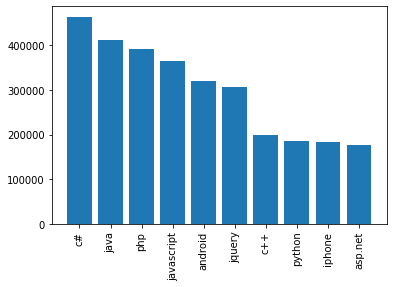

In [133]:
plt.bar(range(len(some_stats)),list(v),tick_label=k)
plt.xticks(rotation='vertical')
plt.show()

## Data Cleaning

In [134]:
del tags_on_dataset
del stats

Remove the duplicate questions.

In [29]:
train_dataset = train_dataset.drop_duplicates(subset="Body", keep="first")

After getting rid of the duplicates, we have 4.1 milion questions.

In [30]:
len(train_dataset)

4154374

Let's save these in a file.

In [33]:
file = r"\JupyterPath\train_dataset_noduplicates"
out_file = open(file,'wb')
pickle.dump(train_dataset, out_file)f
out_file.close()

In [19]:
infile = open(r"\JupyterPath\train_dataset_noduplicates","rb")
train_dataset = pickle.load(infile)
infile.close()

Remove links, html tags, urls, and code fragments from the Body column. They are not needed in this case.

In [36]:
def removeCode(sentence):
    sentence = sentence.replace("\n"," ")
    sentence=re.sub("<code>.*?</code>", ' ', sentence)
    return sentence

def removeHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def removePunctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent.lower()
def removeUrl(sentence):
    return re.sub(r"http\S+", "", sentence)

In [37]:
train_dataset['Body'] = train_dataset['Body'].apply(removeCode)
train_dataset['Body'] = train_dataset['Body'].apply(removeUrl)
train_dataset['Body'] = train_dataset['Body'].apply(removeHtml)
train_dataset['Body'] = train_dataset['Body'].apply(removePunctuation)
train_dataset['Body'] = train_dataset['Body'].apply(keepAlpha)
train_dataset['Title'] = train_dataset['Title'].apply(removePunctuation)

In [38]:
file = r"\train_dataset_cleaned.txt"
outf = open(file,'wb')
pickle.dump(train_dataset, outf)
outf.close()

In [159]:
infile = open(r"\train_dataset_cleaned.txt","rb")
train_dataset = pickle.load(infile)
infile.close()

In [160]:
train_dataset['Body'][200854]

'i had previously thought there was no way to get a users information specifically their userid without first getting them to authenticate your app i see that this page however does that on a custom page tab  not only does this page tab get the viewing users name but it also gets their profile url which includes their userid how do they accomplish this without authentication if this is possible could someone point me to example code where i can see just how it implement it on my own page tabs'

In [161]:
train_dataset['Title'][200854]

'Name UID on page tab without authentication'

## Stemming, Stopword removal

We remove the stopwords(words such as: a, about, this, does, during...) because they don't contribute much.
Also, we do word stemming, to reduce the words to their base form.

In [162]:
stop_words = set(stopwords.words('english'))

In [163]:
def stemming(text):
    """
    Given some text. It will return a list of tokenized words.
    Here we do normalization, stemming, removing stopwords.
    """
    
    tokens = nltk.word_tokenize(text) # Tokenize the text
    tokens = [token for token in tokens if not token in stop_words] #Removing stop words( english)
    
    #Stemming
    eng_stemmer = english_stemmer()
    tokens = [eng_stemmer.stem(token) for token in tokens]
    sentence = " ".join(tokens)
    return sentence

In [164]:
train_dataset['Body'] = train_dataset['Body'].apply(stemming)

In [165]:
train_dataset['Title'] = train_dataset['Title'].apply(stemming)

In [166]:
file = r"\train_dataset_stemming.txt"
outf = open(file,'wb')
pickle.dump(train_dataset, outf)
outf.close()

In [168]:
infile = open(r"\train_dataset_stemming.txt","rb")
train_dataset = pickle.load(infile)
infile.close()

In [169]:
train_dataset.head(5)

,Id,Title,Body,Tags
0,1,how check upload file imag without mime type,id like check upload file imag file e g png jp...,php image-processing file-upload upload mime-t...
1,2,how i prevent firefox close i press ctrl-w,favorit editor vim regular use ctrl w execut c...,firefox
2,3,r error invalid type list variabl,import matlab file construct data frame matlab...,r matlab machine-learning
3,4,how i replac special charact url,probabl simpl simpli find answer basicali want...,c# url encoding
4,5,how modifi whoi contact detail,use modifi function display warn mesag pleas h...,php api file-get-contents


In order to give the title more importance in the tf-idf matrix, I repeat the words three times

In [170]:
train_dataset['Title'] = (train_dataset['Title'] + ' ') * 3

I merge the Title and Body columns into the Text column.

In [171]:
train_dataset['Text'] = train_dataset['Title'] + ' ' + train_dataset['Body']

In [172]:
train_dataset = train_dataset.drop(columns=['Title', 'Body'])
train_dataset = train_dataset[['Id', 'Text', 'Tags']]

In [173]:
train_dataset.head(5)

,Id,Text,Tags
0,1,how check upload file imag without mime type h...,php image-processing file-upload upload mime-t...
1,2,how i prevent firefox close i press ctrl-w how...,firefox
2,3,r error invalid type list variabl r error inva...,r matlab machine-learning
3,4,how i replac special charact url how i replac ...,c# url encoding
4,5,how modifi whoi contact detail how modifi whoi...,php api file-get-contents


Here, we do the TfIdf of the text column.

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [175]:
dataset_text = train_dataset['Text']

In [176]:
dataset_text = dataset_text.to_list()

In [177]:
dataset_text[:10]

['how check upload file imag without mime type how check upload file imag without mime type how check upload file imag without mime type  id like check upload file imag file e g png jpg jpeg gif bmp anoth file problem im use uploadifi upload file chang mime type give text octal someth mime type matter file type upload way check upload file imag apart check file extens use php',
 'how i prevent firefox close i press ctrl-w how i prevent firefox close i press ctrl-w how i prevent firefox close i press ctrl-w  favorit editor vim regular use ctrl w execut certain action quit often happen firefox activ window window still look vim think vim activ window press ctrl w close firefox want way stop ctrl w close firefox rene',
 'r error invalid type list variabl r error invalid type list variabl r error invalid type list variabl  import matlab file construct data frame matlab file contain two column row maintain cell matrix construct datafram run random forest get follow error code import matlab 

In [178]:
x_train = vectorizer.fit_transform(dataset_text)

In [179]:
x_train

<4154374x1043575 sparse matrix of type '<class 'numpy.float64'>'
	with 149222356 stored elements in Compressed Sparse Row format>

## Training

Here I divide the tfidf matrix into train set and test set.

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack

In [181]:
train_set, test_set = train_test_split(x_train, random_state=42, test_size=0.2, shuffle=False)

In [182]:
train_set

<3323499x1043575 sparse matrix of type '<class 'numpy.float64'>'
	with 119508791 stored elements in Compressed Sparse Row format>

In [183]:
test_set

<830875x1043575 sparse matrix of type '<class 'numpy.float64'>'
	with 29713565 stored elements in Compressed Sparse Row format>

Labels of train set and test set

In [184]:
train_set_labels, test_set_labels = train_test_split(train_dataset['Tags'], random_state=42, test_size=0.2, shuffle=False)

In [185]:
del train_dataset

In [186]:
train_set_labels.shape

(3323499,)

In [187]:
test_set_labels.shape

(830875,)

In [188]:
y_train = train_set_labels.to_list()
y_test = test_set_labels.to_list()

In [189]:
y_train[0:5]

['php image-processing file-upload upload mime-types',
 'firefox',
 'r matlab machine-learning',
 'c# url encoding',
 'php api file-get-contents']

We got the labels as list of strings, we have to convert them as list of lists, where each element in the inner list is a label(tag).

In [190]:
y_train = [y_train[i].split(" ") for i in range(0, len(y_train))]

In [196]:
y_train[:5]

[['php', 'image-processing', 'file-upload', 'upload', 'mime-types'],
 ['firefox'],
 ['r', 'matlab', 'machine-learning'],
 ['c#', 'url', 'encoding'],
 ['php', 'api', 'file-get-contents']]

In [106]:
y_test = [y_test[i].split(" ") for i in range(0, len(y_test))]

In [107]:
len(y_test)

830875

In [192]:
y_test[:5]

['xcode compilation objective-c++',
 'java android youtube youtube-api',
 'wpf binding mvvm',
 'colors pdf-reader',
 'delphi compiler']

I'm going to do training with 1000 labels at a time. So in the most_most_common_sample, I read the 6000 labels in chunks of 1000 labels.

In [115]:
def chunks_most_common(l, n):
    """Get the next 1000 tags from the most common tags, and return them."""
    return (l[i:i+n] for i in range(0, len(l), n))

In [116]:
def next_y_samples(chunks_of_tags, y):
    """Checks if the tags on each sublist of the y are on the most_common_sample.
       If they are, return them in a list."""
    
    y_sample = [[row[i] for i in range(0, len(row)) if row[i] in chunks_of_tags] for row in y]
    return y_sample

In [58]:
import datetime

def training(train_set, y_train, most_common_tags, n, file_path):
    pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+'
    vectorizer = CountVectorizer(token_pattern=pattern)
    file_index = 1000
    for chunk in chunks_most_common(most_common_tags, n):
        y_train_sample = next_y_samples(chunk, y_train)
        tokenized_list = [' '.join(inner_list) for inner_list in y_train_sample]
        y_tr = vectorizer.fit_transform(tokenized_list)
        print("y_tr done at: ", datetime.datetime.now().time())
        ovr_clf = OneVsRestClassifier(SGDClassifier(loss='log'), n_jobs=-1)
        ovr_clf.fit(train_set, y_tr)
        print("ovr_clf.fit done at: ", datetime.datetime.now().time())
        outf = open(file_path + 'ovr_clf_' + str(file_index), 'wb')
        pickle.dump(ovr_clf, outf)
        print("dump done at: ", datetime.datetime.now().time())
        file_index += 1000
        outf.close()

I train the model using OneVsRestClassifier, 1000 labels at a time(because training the model with all 6000 labels at the same time was taking way too much time).

In [59]:
training(train_set, y_train, most_common_tags, 1000, '\\')

y_tr done at:  11:32:41.044081
ovr_clf.fit done at:  12:30:15.197907
dump done at:  12:45:58.333900
y_tr done at:  12:55:15.595105
ovr_clf.fit done at:  13:51:45.465665
dump done at:  14:05:39.457322
y_tr done at:  14:13:29.637288
ovr_clf.fit done at:  15:09:48.684103
dump done at:  15:23:22.448306
y_tr done at:  15:31:17.384098
ovr_clf.fit done at:  16:27:41.594551
dump done at:  16:43:42.930662
y_tr done at:  16:52:31.789133
ovr_clf.fit done at:  17:49:51.041468
dump done at:  18:05:49.558325
y_tr done at:  18:14:14.916918
ovr_clf.fit done at:  19:10:26.994795
dump done at:  19:23:47.343035


I save these training files into disk. In total, there are 6 files, 8GB each.

Below, we do the predictions on the test set.
For every sample, if the probability of a label is less than 20%, make it zero otherwise keep its value. This makes most labels zero, except few of them will keep their value.
We convert the predictions ndarray to csr_matrix, since most of the elements are zero, it will be much better to save it in a sparse matrix.
We dump the predictions using pickle.
This will give us 6 predictions in csr format.

In [11]:
from scipy import sparse

In [45]:
import datetime

def predictions(test_set, number_of_files, files_to_read, files_to_write):
    file_index = 1000
    for i in range(number_of_files):
        infile = open(files_to_read + str(file_index), "rb")
        ovr_clf = pickle.load(infile)
        predictions = ovr_clf.predict_proba(test_set)
        predictions = (predictions >= 0.2) * predictions
        predictions_csr = sparse.csr_matrix(predictions)
        outf = open(files_to_write+str(file_index), 'wb')
        pickle.dump(predictions_csr, outf)
        print("prediction {} done at:{} ".format(i+1, datetime.datetime.now().time()))
        file_index += 1000
        infile.close()
        outf.close()

In [46]:
predictions(test_set, 6, r"\ovr_clf_", r"\predictions_csr_")

prediction 1 done at:13:12:18.375606 
prediction 2 done at:13:49:55.381849 
prediction 3 done at:14:28:09.173800 
prediction 4 done at:15:07:57.608070 
prediction 5 done at:15:45:57.765528 
prediction 6 done at:16:27:21.360085 


In [47]:
from scipy.sparse import csr_matrix, hstack

Stack the matrices horizontally. We will get a matrix with 6000 columns(which is the number of labels).

In [85]:
def stack_matrices_horizontally(number_of_files, files_to_read, file_to_write):
    file_index = 1000
    infile = open(files_to_read + str(file_index), "rb")
    final_predictions = pickle.load(infile)

    for i in range(number_of_files):
        file_index += 1000
        infile = open(files_to_read + str(file_index), "rb")
        next_predictions = pickle.load(infile)
        final_predictions = hstack([final_predictions, next_predictions])
        infile.close()
        
    final_predictions = final_predictions.tocsr()
    outfile = open(file_to_write, "wb")
    pickle.dump(final_predictions, outfile)
    outfile.close()

In [86]:
stack_matrices_horizontally(5, r"\predictions_csr_", r"\final_predictions_matrix")

In [21]:
file = r"\final_predictions_matrix"
infile = open(file, "rb")
final_predictions = pickle.load(infile)
infile.close()

In [22]:
final_predictions

<830875x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 503309 stored elements in Compressed Sparse Row format>

In [23]:
final_predictions_lil = final_predictions.tolil()

In [25]:
for i in range(0, final_predictions_lil.shape[0]):
    if (final_predictions_lil[i].count_nonzero()) > 5:
        sorted_values = -np.sort(-final_predictions_lil[i].toarray().flatten())
        sorted_values = sorted_values[0:5]
        
        for j in range(0, final_predictions_lil.shape[1]):
            if final_predictions_lil[i, j] not in sorted_values:
                final_predictions_lil[i, j] = 0

In [26]:
final_predictions_lil

<830875x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 503275 stored elements in LInked List format>

In [27]:
final_predictions_coo = sparse.coo_matrix(final_predictions_lil)

In [28]:
for i, j, v in zip(final_predictions_coo.row, final_predictions_coo.col, final_predictions_coo.data):
    if v > 0:
        final_predictions_lil[i, j] = 1

In [71]:
file = r"\final_predictions_lil"
outf = open(file,'wb')
pickle.dump(final_predictions_lil, outf)
outf.close()

In [72]:
file = r"\final_predictions_lil"
infile = open(file, "rb")
final_predictions_lil = pickle.load(infile)
infile.close()

In [73]:
from scipy.sparse import csr_matrix, find
find(final_predictions_lil)

(array([   905,   1679,   2025, ..., 815102, 818428, 829213], dtype=int32),
 array([  0,   0,   0, ..., 998, 998, 998], dtype=int32),
 array([1., 1., 1., ..., 1., 1., 1.]))

In [74]:
final_predictions_lil

<830875x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 503275 stored elements in LInked List format>

In [140]:
def get_features(n):
    feature_names = []
    index = 1000
    pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+'
    vectorizer = CountVectorizer(token_pattern=pattern)
    
    for chunk in chunks_most_common(most_common_tags, n):
        y_t_s = next_y_samples(chunk, y_train)
        tokenized_list = [' '.join(inner_list) for inner_list in y_t_s]
        y_t = vectorizer.fit_transform(tokenized_list)
        feature_names.extend(vectorizer.get_feature_names())
        index += 1000
    return feature_names

In [144]:
feature_names = get_features(1000)

In [193]:
pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+'
vectorizer2 = CountVectorizer(vocabulary=feature_names)
tokenized_list = [' '.join(inner_list) for inner_list in y_test]
y_ts = vectorizer2.fit_transform(y_test)

In [194]:
file = r"\y_ts"
outf = open(file,'wb')
pickle.dump(y_ts, outf)
outf.close()

In [195]:
file = r"\y_ts"
infile = open(file, "rb")
y_ts = pickle.load(infile)
infile.close()

In [197]:
find(y_ts)

(array([   386,   1182,   1213, ..., 684133, 760387, 825947]),
 array([   5,    5,    5, ..., 5999, 5999, 5999]),
 array([1, 1, 1, ..., 1, 1, 1], dtype=int64))

In [198]:
find(final_predictions_lil)

(array([   905,   1679,   2025, ..., 815102, 818428, 829213], dtype=int32),
 array([  0,   0,   0, ..., 998, 998, 998], dtype=int32),
 array([1., 1., 1., ..., 1., 1., 1.]))

In [229]:
non_zeros = y_ts.count_nonzero()
true_labels = y_ts.tocoo()

count = 0
for i, j in zip(true_labels.row, true_labels.col):
    if final_predictions_lil[i, j] == 1:
        count += 1

accuracy = count / non_zeros
print("The model found: {:.2f} % of the correct tags.".format(accuracy * 100))

The model found: 14.30 % of the correct tags.
